In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import mstats
from scipy.stats import pearsonr, gaussian_kde
from sklearn.metrics import r2_score
from scipy.spatial.distance import jensenshannon

In [22]:
config = {
    # !! 修改为你自己的文件路径和名称 !!
    # 'data_file': './data2/filtered_data.xlsx',
    # 'model_dir': './model/', # 模型保存目录
    # 'model_file': './model/corrected_nn_model.pkl', # 模型文件名
    # 'sheet_name': 'Sheet1', # Excel中的工作表名
    # 'output_pred': './data2/predictions_nn.xlsx', # 预测结果保存路径

    # !! 修改为你的特征列和目标列名称 !!
    # 'x_columns': [
    #     '煤气进口流量', '进口煤气温度', '进口煤气压力', '脱硫液流量',
    #     '脱硫液温度', '脱硫液压力', '转速', '进口H2S浓度'
    # ],
    # 'y_column': '出口H2S浓度',


    'data_file': './data/dataset.xlsx',
    'model_dir': './model/',  # 模型保存目录
    'model_file': './model/corrected_nn_model1.pkl',  # 模型文件名
    'sheet_name': 'Sheet2',  # Excel中的工作表名
    'output_pred': './data/predictions_nn.xlsx',  # 预测结果保存路径

    'x_columns': [
        'gas_flow', 'liquid_flow', 'frequency'
    ],
    'y_column': 'H2S_concentration',


    # 模型和训练参数
    'test_size': 0.2,
    'random_state': 42,
    'poly_degree': 2, # 多项式特征次数
    'mlp_hidden_layers': (256, 128, 64, 32, 16), # 神经网络隐藏层结构
    'mlp_max_iter': 5000, # 最大迭代次数
    'shap_sample_size': 100, # 用于 SHAP 计算的样本数量
    'use_early_stopping': False, # 新增：是否使用早停法
    'n_iter_no_change': 20,    # 新增：早停法 patience 参数
    'validation_fraction': 0.15 # 新增：早停法验证集比例
}

In [23]:
def load_and_preprocess_data(data_file, sheet_name, x_columns, y_column, poly_degree, test_size, random_state):
    """加载、预处理数据并分割"""
    print(">> 1. 读取并预处理数据...")
    try:
        df = pd.read_excel(data_file, sheet_name=sheet_name)
    except FileNotFoundError:
        print(f"错误：无法找到文件 {data_file}")
        return None, None, None, None, None, None, None, None
        
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # Winsorization 处理异常值 (对数值型特征列进行处理)
    print("   - Winsorization 处理异常值...")
    numeric_x_columns = df[x_columns].select_dtypes(include=np.number).columns
    for col in numeric_x_columns:
        df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])

    X = df[x_columns]
    y = df[y_column]

    # 添加多项式特征
    print(f"   - 添加 {poly_degree} 次多项式和交互特征...")
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=False, include_bias=False)
    X_poly = poly.fit_transform(X)
    # 获取特征名称，注意适配新版sklearn
    try:
      feature_names = poly.get_feature_names_out(X.columns)
    except AttributeError: # 兼容旧版本
      feature_names = poly.get_feature_names(X.columns)
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index=df.index)

    # 分割数据集
    print("   - 分割训练集和测试集...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_poly_df, y, test_size=test_size, random_state=random_state
    )

    # 标准化
    print("   - 标准化特征...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 转换为 DataFrame 并保留特征名称
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_poly_df.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_poly_df.columns, index=X_test.index)

    print("   - 训练数据维度:", X_train_scaled_df.shape)
    print("   - 数据预处理完成.")
    return df, X_train_scaled_df, X_test_scaled_df, y_train, y_test, scaler, poly, feature_names

In [24]:
def train_or_load_model(model_file, X_train_scaled_df, y_train, hidden_layers, max_iter, random_state, use_early_stopping, n_iter_no_change, validation_fraction):
    """训练新的MLP模型或加载已存在的模型"""
    warnings.filterwarnings("ignore", category=ConvergenceWarning) # 忽略收敛警告

    model_dir = os.path.dirname(model_file)
    if model_dir and not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f">> 创建模型目录: {model_dir}")

    if os.path.exists(model_file):
        print(f">> 2. 加载已有模型: {model_file}")
        try:
            mlp = joblib.load(model_file)
            print("   - 模型加载成功.")
            return mlp
        except Exception as e:
            print(f"   - 加载模型失败: {e}. 将训练新模型。")

    print(">> 2. 训练新神经网络模型...")
    mlp = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate='adaptive',
        early_stopping=use_early_stopping, # 使用配置中的早停参数
        validation_fraction=validation_fraction,
        n_iter_no_change=n_iter_no_change,
        max_iter=max_iter,
        random_state=random_state,
        verbose=False
    )
    mlp.fit(X_train_scaled_df, y_train)

    # --- 修改在这里 ---
    # 检查 best_loss_ 是否为 None，然后决定如何打印
    best_loss_str = f"{mlp.best_loss_:.4f}" if mlp.best_loss_ is not None else "N/A"
    print(f"   - 模型训练完成. 最终迭代次数: {mlp.n_iter_}, 最低损失: {best_loss_str}")
    # --- 修改结束 ---

    # 保存模型
    try:
        joblib.dump(mlp, model_file)
        print(f"   - 模型已保存至: {model_file}")
    except Exception as e:
        print(f"   - 模型保存失败: {e}")

    warnings.filterwarnings("default", category=ConvergenceWarning) # 恢复警告
    return mlp

In [25]:
def evaluate_model(model, X_test_scaled_df, y_test):
    """评估模型性能"""
    print("\n>> 3. 模型评估...")
    y_pred = model.predict(X_test_scaled_df)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"   - 平均绝对误差 (MAE) : {mae:.4f}")
    print(f"   - 均方根误差 (RMSE): {rmse:.4f}")
    print(f"   - R² 分数          : {r2:.4f}")
    print("   - 评估完成.")
    return y_pred


In [26]:
def predict_and_save(df_original, model, scaler, poly, x_columns, y_column, poly_feature_names, out_excel):
    """对整个数据集进行预测并保存结果"""
    print("\n>> 4. 全量数据预测...")
    X_all = df_original[x_columns]

    # 应用相同的预处理步骤
    X_all_poly = poly.transform(X_all)
    X_all_scaled = scaler.transform(X_all_poly)

    # 使用与训练时相同的特征名称创建DataFrame
    X_all_scaled_df = pd.DataFrame(X_all_scaled, columns=poly_feature_names, index=df_original.index)

    df_pred = df_original.copy()
    df_pred['Predicted_' + y_column] = model.predict(X_all_scaled_df)

    # 保存结果
    out_dir = os.path.dirname(out_excel)
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir)

    try:
        df_pred.to_excel(out_excel, index=False)
        print(f"   - 预测结果已保存至: {out_excel}")
    except Exception as e:
        print(f"   - 保存预测结果失败: {e}")
    print("   - 全量预测完成.")
    return df_pred

In [27]:
from scipy.stats import gaussian_kde

def plot_evaluation_results_v2(y_true, y_pred, title='Actual vs Predicted'):
    """绘制实际值 vs 预测值图，并添加KDE密度图层"""
    print("   - 绘制增强版实际值与预测值散点图（带KDE）...")

    # 确保是 numpy 数组
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # 计算 KDE 颜色密度
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()

    # 根据密度排序
    x_sorted, y_sorted, z_sorted = y_true[idx], y_pred[idx], z[idx]

    # 绘图
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_sorted, y_sorted, c=z_sorted, cmap='viridis', s=30, edgecolor='k', alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', label='理想预测')
    plt.xlabel('真实值', fontsize=12)
    plt.ylabel('预测值', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.colorbar(scatter, label='密度估计值')
    plt.tight_layout()
    plt.savefig('actual_vs_predicted_enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()


In [28]:
def plot_residual_distribution_v2(y_true, y_pred, title='Residual Distribution'):
    """绘制现代风格残差分布图（含核密度估计）"""
    print("   - 绘制增强版残差图（含KDE 和统计信息）...")

    # 计算残差
    residuals = y_pred - y_true
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)

    # 绘图
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30, color="skyblue", edgecolor='k', linewidth=0.5, alpha=0.7)

    # 添加参考线（0 线）
    plt.axvline(0, color='gray', linestyle='--', label='残差 = 0')

    # 添加统计信息
    stats_text = f'Mean: {mean_res:.3f}\nStd: {std_res:.3f}'
    plt.text(0.97, 0.95, stats_text, transform=plt.gca().transAxes,
             horizontalalignment='right', verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))

    # 美化
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('残差值 (Predicted - True)', fontsize=12)
    plt.ylabel('频数', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('enhanced_residual_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [29]:
def plot_shap_summary(model, X_train_scaled_df, feature_names, sample_size):
    """绘制SHAP特征重要性摘要图"""
    print("   - 生成SHAP特征重要性图...")
    # 由于 KernelExplainer 较慢，通常使用训练数据的子集
    if len(X_train_scaled_df) > sample_size:
        X_shap = shap.sample(X_train_scaled_df, sample_size, random_state=config['random_state'])
        print(f"     (使用 {sample_size} 个样本进行SHAP计算)")
    else:
        X_shap = X_train_scaled_df

    # 创建解释器，注意 KernelExplainer 需要一个返回单个输出的预测函数
    # 对于回归，model.predict 本身就可以
    explainer = shap.KernelExplainer(model.predict, X_shap)

    # 计算 SHAP 值 (这步可能比较耗时)
    print("     正在计算SHAP值，请稍候...")
    try:
        shap_values = explainer.shap_values(X_shap)

        # 绘制 SHAP 摘要图
        print("     绘制SHAP摘要图...")
        plt.figure() # 创建新图形，避免覆盖之前的图
        shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
        # 获取当前图形的引用并调整布局
        fig = plt.gcf()
        fig.set_size_inches(10, 6) # 调整图形大小
        plt.title('SHAP 特征重要性摘要图')
        plt.tight_layout()
        # plt.show() # 暂时不显示
    except Exception as e:
        print(f"     计算或绘制 SHAP 图时出错: {e}")
        print("     SHAP 图可能无法生成。")


def plot_loss_curve(model):
    """绘制模型的训练损失曲线"""
    if hasattr(model, 'loss_curve_'):
        print("   - 绘制模型训练损失曲线...")
        plt.figure(figsize=(8, 5))
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.plot(model.loss_curve_, label='训练损失 (Training Loss)', color='royalblue', lw=2)

        # 如果使用了早停并且有验证分数，也绘制出来
        if hasattr(model, 'validation_scores_') and model.early_stopping:
            # 计算验证集损失 (注意: validation_scores_ 是 R^2 或其他分数，不是直接的loss)
            # MLPRegressor 存储的是 best_validation_score_ 和 validation_scores_ (通常是 R^2)
            # 要绘制验证 *损失*，需要模型内部支持或手动计算，这里我们只画训练损失
            # 如果需要验证损失，训练时需要手动分割验证集并记录每次迭代的验证损失
            # print("     (注意: 验证分数(R²)可用，但验证损失曲线未直接提供)")
            pass # 暂时不画验证损失，因为 MLPRegressor 不直接暴露

        plt.xlabel('迭代次数 (Epochs)')
        plt.ylabel('损失值 (Loss)')
        plt.title('模型训练损失曲线')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show() # 暂时不显示
    else:
        print("   - 未找到损失曲线数据 (模型可能未训练或从文件加载)。")

===== 神经网络预测与评估程序 =====
>> 1. 读取并预处理数据...
   - Winsorization 处理异常值...
   - 添加 2 次多项式和交互特征...
   - 分割训练集和测试集...
   - 标准化特征...
   - 训练数据维度: (593, 9)
   - 数据预处理完成.
>> 2. 加载已有模型: ./model/corrected_nn_model1.pkl
   - 模型加载成功.

>> 3. 模型评估...
   - 平均绝对误差 (MAE) : 0.6983
   - 均方根误差 (RMSE): 1.1114
   - R² 分数          : 0.9919
   - 评估完成.

>> 4. 全量数据预测...


D:\python\envs\test\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


   - 预测结果已保存至: ./data/predictions_nn.xlsx
   - 全量预测完成.

>> 5. 生成可视化图表...
   - 绘制增强版实际值与预测值散点图（带KDE）...


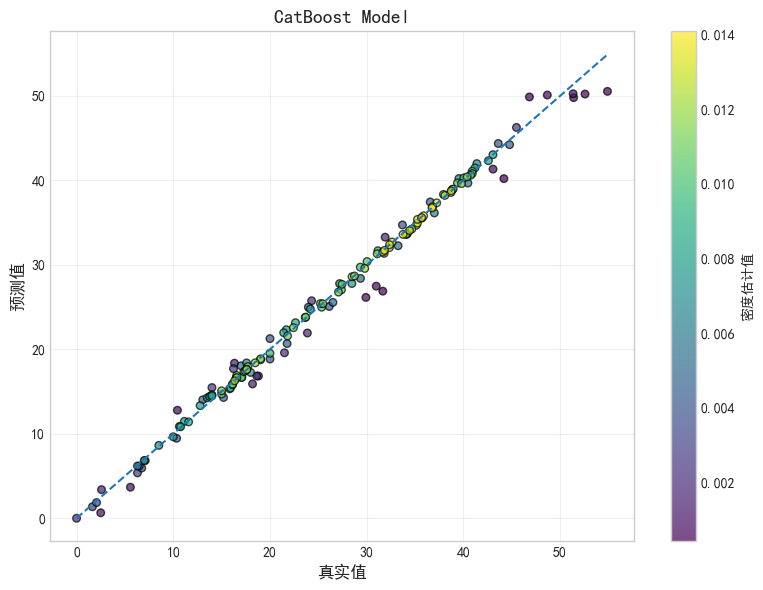

   - 绘制增强版残差图（含KDE 和统计信息）...


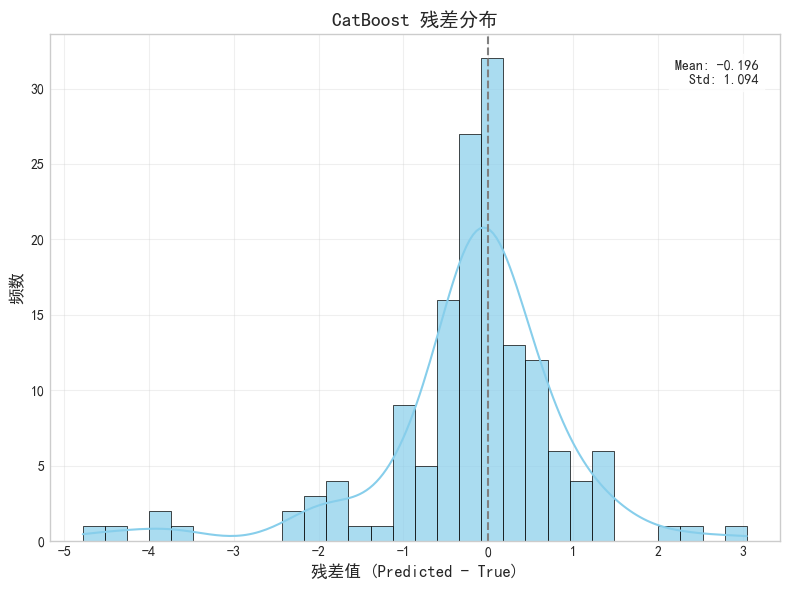

   - 生成SHAP特征重要性图...
     (使用 100 个样本进行SHAP计算)
     正在计算SHAP值，请稍候...


  0%|          | 0/100 [00:00<?, ?it/s]

     绘制SHAP摘要图...
   - 绘制模型训练损失曲线...


C:\Users\11316\AppData\Local\Temp\ipykernel_11808\3785935479.py:57: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\11316\AppData\Local\Temp\ipykernel_11808\3785935479.py:57: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\11316\AppData\Local\Temp\ipykernel_11808\3785935479.py:57: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\11316\AppData\Local\Temp\ipykernel_11808\3785935479.py:57: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\11316\AppData\Local\Temp\ipykernel_11808\3785935479.py:57: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\11316\AppData\Local\Temp\ipykernel_11808\3785935479.py:57: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931})

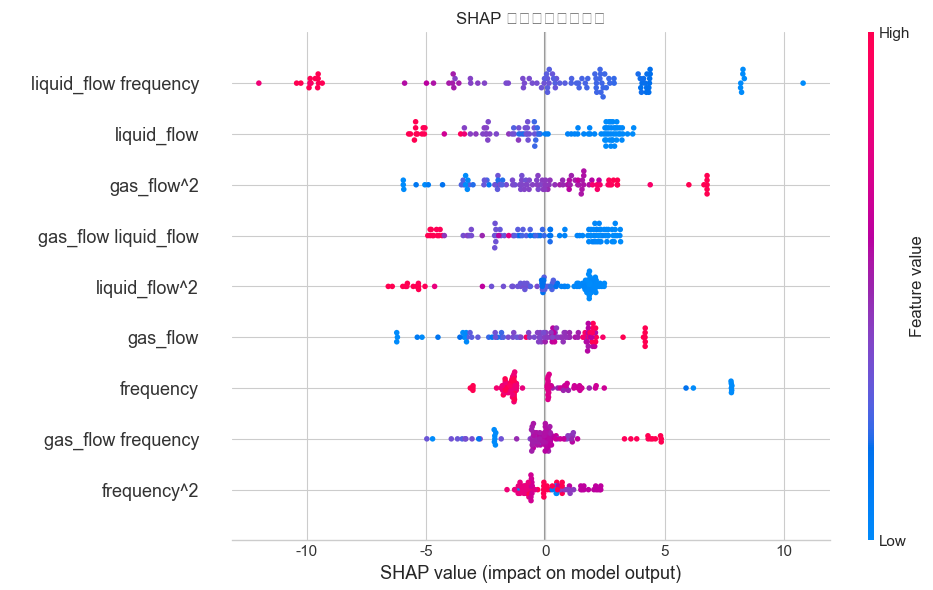

D:\python\envs\test\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python\envs\test\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python\envs\test\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python\envs\test\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python\envs\test\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python\

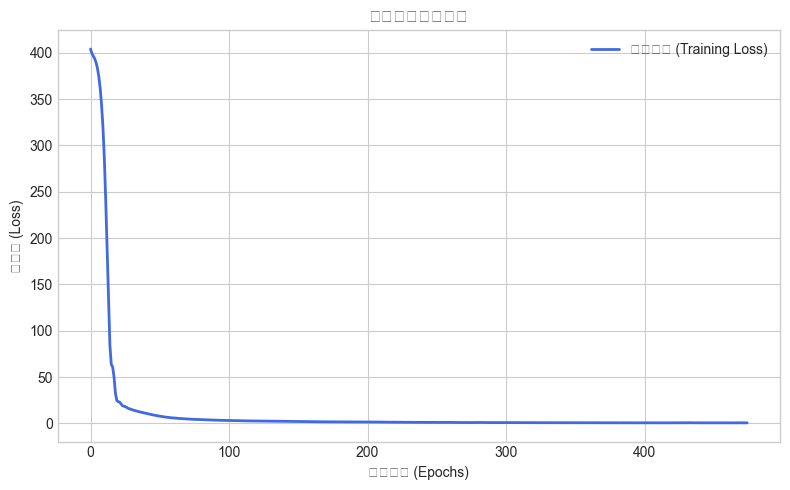

   - 显示所有图表...

===== 程序执行完毕 =====


In [30]:
print("===== 神经网络预测与评估程序 =====")
cfg = config # 使用定义的配置


# 1. 数据加载与预处理
df_orig, X_train_scaled, X_test_scaled, y_train, y_test, scaler, poly, feature_names = load_and_preprocess_data(
    cfg['data_file'], cfg['sheet_name'], cfg['x_columns'], cfg['y_column'],
    cfg['poly_degree'], cfg['test_size'], cfg['random_state']
)
if df_orig is None:
    print("无法加载数据，程序退出。")
       

# 2. 模型训练/加载
model = train_or_load_model(
    cfg['model_file'], X_train_scaled, y_train,
    cfg['mlp_hidden_layers'], cfg['mlp_max_iter'], cfg['random_state'],
    cfg['use_early_stopping'], cfg['n_iter_no_change'], cfg['validation_fraction'] # 传递早停参数
)
if model is None:
    print("无法训练或加载模型，程序退出。")
        

# 3. 模型评估
y_pred_test = evaluate_model(model, X_test_scaled, y_test)

# 4. 全量预测与保存
df_predictions = predict_and_save(
    df_orig, model, scaler, poly, cfg['x_columns'], cfg['y_column'], feature_names, cfg['output_pred']
)

# 5. 可视化
print("\n>> 5. 生成可视化图表...")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文字体(例如 SimHei)
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 5.1 评估结果图 (测试集)
# plot_evaluation_results(y_test, y_pred_test, title_suffix='(测试集)')
plot_evaluation_results_v2(y_test, y_pred_test, title='CatBoost Model')
plot_residual_distribution_v2(y_test, y_pred_test, title='CatBoost 残差分布')

# 5.2 SHAP 特征重要性图 (基于训练集子集)
plot_shap_summary(model, X_train_scaled, feature_names, cfg['shap_sample_size'])

# 5.3 训练损失曲线
plot_loss_curve(model)

# 显示所有图形
print("   - 显示所有图表...")
plt.show()

print("\n===== 程序执行完毕 =====")
    